In [101]:
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import numpy as np

from collections import Counter

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.stem import WordNetLemmatizer

from wordcloud import WordCloud

data = pd.read_csv('/kaggle/input/bidenreddit/JoeBiden_comments_2020_clean.csv')
data.head()

Unnamed: 0          author  \
0           0   nightcloudsky   
1           1  PotGetsStirred   
2           2     MayorShield   
3           3         elisart   
4           4     UmmahSultan   

                                                body  created_utc    link_id  \
0  I feel like I am becoming one with universe ac...   1577837280  t3_eia4d6   
1  Thanks for reminding me to go donate a downvot...   1577837752  t3_ei9uvo   
2  Any young Biden supporters here? By young, I m...   1577838121  t3_ei240i   
3  Never even thought of her but she would be gre...   1577838787  t3_eiajnx   
4  Even being within the margin of error in a whi...   1577838809  t3_eia4d6   

    parent_id  score  
0  t1_fcokn8b      1  
1   t3_ei9uvo      1  
2   t3_ei240i      1  
3  t1_fcolgkj      1  
4  t1_fcokn8b      1

In [102]:
data.shape

(499528, 7)

In [103]:
data_score = data[data['score'] > 1] 
data_score.shape

(2333, 7)

In [104]:
data_score = data[data['score'] > 0] 
data_score.shape

(499418, 7)

Очень мало кто получает больше одного лайка, но почти все посты получают хотя бы один лайк. Если не ошибаюсь, на реддите ты автоматически после публикации начинаешь с одним лайком, так что дело в этом скорее всего. 

In [105]:
data_author = data['author'].value_counts().rename_axis('nickname').to_frame('posts_count')
data_author.reset_index(inplace = True)
data_author.head()

nickname  posts_count
0       backpackwayne         3931
1             40for60         3211
2  rikki-tikki-deadly         2738
3       HonoredPeople         2276
4       MaimedPhoenix         2194

Посмотрим, кто вообще сколько постов оставил. 

In [106]:
data_author['posts_count'].mean()

10.055518650482114

In [107]:
data_author['posts_count'].median()

2.0

Медиана маленькая, среднее тоже. Большая часть людей не пишет часто о политике. Попробуем посмотреть на тех, кто пишет и сколько их. 

In [108]:
data_author.shape

(49677, 2)

In [109]:
data_author[data_author['posts_count'] > 10].shape

(6483, 2)

In [110]:
data_author[data_author['posts_count'] > 1000].shape

(21, 2)

In [111]:
data_author[data_author['posts_count'] > 500].shape

(96, 2)

Рекордсменов, которые написали больше тысячи постов, всего два десятка. Возможно стоило бы попытаться как-то понять не боты ли это, но у меня нет четких идей. 

In [112]:
over_thousand_posts = data_author[data_author['posts_count'] > 1000]


Распределение постов среди авторов с более чем тысячей. Один конкретный выделяется прям сильно.

<AxesSubplot:xlabel='nickname'>

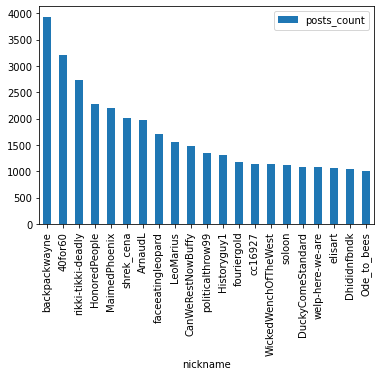

In [113]:
over_thousand_posts.plot(kind = 'bar', x = 'nickname', y = 'posts_count')

Посмотел самые популярные посты, на случай если там будет что-то прям примечательное. 

Text(0, 0.5, 'Title')

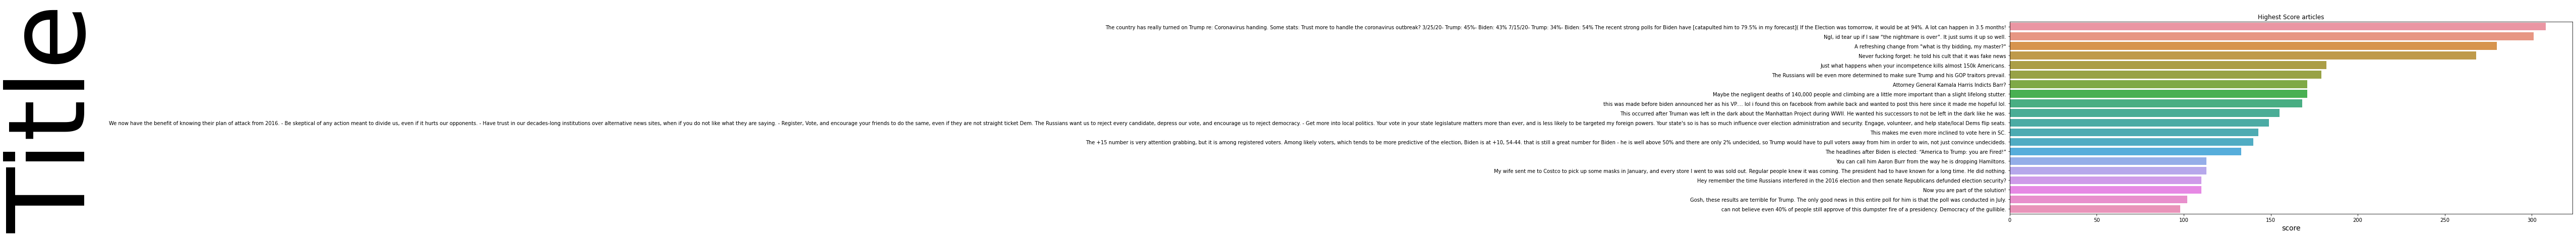

In [114]:
data_score = data.sort_values('score', ascending=False).head(20)
plt.figure(figsize=(20,7))
plt.title('Highest Score articles')
sns.barplot(y=data_score['body'],x=data_score['score'])
plt.xlabel('score',fontsize=14)
plt.ylabel('Title',fontsize=212)

In [115]:
data['time'] = pd.to_datetime(data['created_utc'], unit = 's')

In [116]:
data.head()

Unnamed: 0          author  \
0           0   nightcloudsky   
1           1  PotGetsStirred   
2           2     MayorShield   
3           3         elisart   
4           4     UmmahSultan   

                                                body  created_utc    link_id  \
0  I feel like I am becoming one with universe ac...   1577837280  t3_eia4d6   
1  Thanks for reminding me to go donate a downvot...   1577837752  t3_ei9uvo   
2  Any young Biden supporters here? By young, I m...   1577838121  t3_ei240i   
3  Never even thought of her but she would be gre...   1577838787  t3_eiajnx   
4  Even being within the margin of error in a whi...   1577838809  t3_eia4d6   

    parent_id  score                time  
0  t1_fcokn8b      1 2020-01-01 00:08:00  
1   t3_ei9uvo      1 2020-01-01 00:15:52  
2   t3_ei240i      1 2020-01-01 00:22:01  
3  t1_fcolgkj      1 2020-01-01 00:33:07  
4  t1_fcokn8b      1 2020-01-01 00:33:29

Посмотрим распределение количества постов по времени.

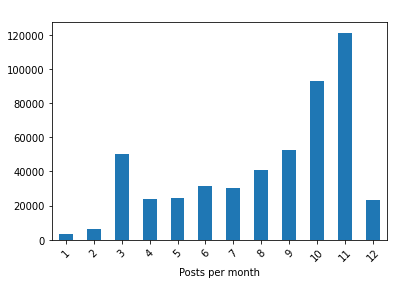

In [117]:
plt.title('Posts Distribution', color = 'white', size = 12)
month_data = data.groupby(data["time"].dt.month).time.count()
month_data.plot(kind = "bar")
plt.xlabel('Posts per month')
plt.xticks(rotation = 45)
plt.show()

Интересно. Понятный всплеск в октябре и ноябре, всплеск в марте может быть обоснован ковидом. ОЧЕНЬ резкое снижение активности сразу после выборов, интересно сравнить с сторонниками Трампа. 

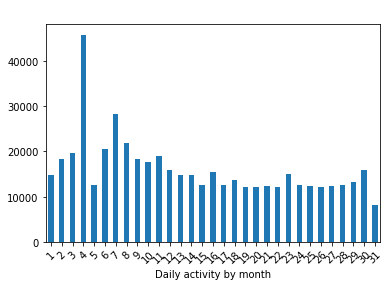

In [118]:
plt.title('Posts Distribution', color = 'white', size = 15)
month_data = data.groupby(data["time"].dt.day).time.count()
month_data.plot(kind = "bar")
plt.xlabel('Daily activity by month')
plt.xticks(rotation = 45)
plt.show()

Все логично, получаем сильную активость в день выборов. Что такое 7е число затрудняюсь сказать. 

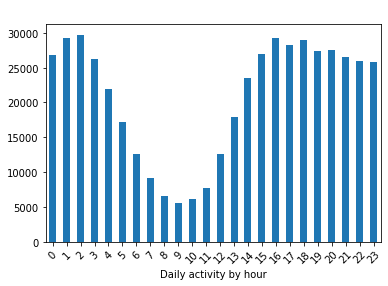

In [119]:
plt.title('Posts Distribution', color = 'white', size = 15)
month_data = data.groupby(data["time"].dt.hour).time.count()
month_data.plot(kind = "bar")
plt.xlabel('Daily activity by hour')
plt.xticks(rotation = 45)
plt.show()

В принципе ничего необычного, людям надо спать даже когда они спорят о политике. Посмотрим еще распределение лайков, на случай если в нем есть что-то необычное. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 2 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)


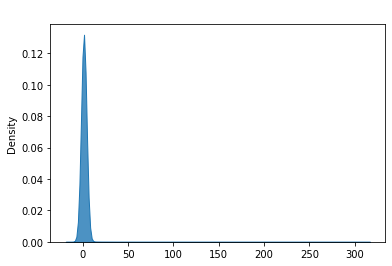

In [120]:
plt.title('Posts score', color = 'white', size = 15)
sns.kdeplot(data['score'], shade = True, 
            alpha = .8, legend = None, bw = 2)
plt.xlabel('')
plt.show()

Глянем суммарное число лайков по авторам и как оно соотносится с количеством постов. 

In [121]:
data_sc= pd.DataFrame(data.groupby('author').agg({'score':['sum']}))
data_sc.columns = ['sum']

data_sc = data_sc.reset_index()

In [122]:
data_sc['sum'].median()

2.0

In [123]:
data_sc['sum'].mean()

10.503995812951668

Медиана и среднее очень похожи на количество постов. Получается тех у кого много залайканных постов должно быть мало. Можно попытаться выделить их. 

In [124]:
data_sc[data_sc['sum'] > 10].shape

(6603, 2)

In [125]:
data_sc[data_sc['sum'] > 1000].shape

(30, 2)

In [126]:
data_sc.head()


author  sum
0  ------2loves------    1
1  ----0000000-------    1
2                ---E    1
3         ---Reset---    1
4          ---heat---    3

In [127]:
data_score.head()

Unnamed: 0             author  \
156986      156986         edgar-reed   
230195      230195  amiamanoramiababy   
159189      159189   politicalthrow99   
156611      156611   politicalthrow99   
157045      157045      Nextravagant1   

                                                     body  created_utc  \
156986  The country has really turned on Trump re: Cor...   1595132552   
230195  Ngl, id tear up if I saw “the nightmare is ove...   1600038146   
159189  A refreshing change from "what is thy bidding,...   1595289980   
156611  Never fucking forget: he told his cult that it...   1595104895   
157045  Just what happens when your incompetence kills...   1595136043   

          link_id   parent_id  score  
156986  t3_htuedr   t3_htuedr    308  
230195  t3_is8t8g   t3_is8t8g    301  
159189  t3_huw2m4   t3_huw2m4    280  
156611  t3_htmdmv   t3_htmdmv    268  
157045  t3_htuedr  t1_fyj2wyn    182

In [128]:
over_thousand_sumscore = data_sc[data_sc['sum'] > 1000]

In [129]:
over_thousand_posts.head()

nickname  posts_count
0       backpackwayne         3931
1             40for60         3211
2  rikki-tikki-deadly         2738
3       HonoredPeople         2276
4       MaimedPhoenix         2194

In [130]:
over_thousand_posts = over_thousand_posts.rename(columns={"nickname": "author"})

In [131]:
over_thousand_intersection = pd.merge(over_thousand_posts, over_thousand_sumscore, how ='inner', on = ['author'])

In [132]:
over_thousand_intersection.head()

author  posts_count   sum
0       backpackwayne         3931  4197
1             40for60         3211  3213
2  rikki-tikki-deadly         2738  2848
3       HonoredPeople         2276  2308
4       MaimedPhoenix         2194  2216

In [133]:
over_thousand_intersection.shape 

(21, 3)

Больше тысячи постов и суммарное число лайков больше тысячи пересекаются ровно по тем у кого больше тысячи постов. 

In [134]:
over_thousand = pd.merge(over_thousand_posts, over_thousand_sumscore, how ='outer', on = ['author'])

In [135]:
over_thousand.shape

(30, 3)

In [136]:
over_thousand


author  posts_count   sum
0          backpackwayne       3931.0  4197
1                40for60       3211.0  3213
2     rikki-tikki-deadly       2738.0  2848
3          HonoredPeople       2276.0  2308
4          MaimedPhoenix       2194.0  2216
5             shrek_cena       2018.0  2018
6                ArnaudL       1978.0  1996
7      faceeatingleopard       1712.0  2036
8              LeoMarius       1548.0  1713
9      CanWeRestNowBuffy       1475.0  1478
10      politicalthrow99       1353.0  2102
11           Historyguy1       1300.0  1415
12           fouriergold       1170.0  1192
13               cc16927       1143.0  1159
14  WickedWenchOfTheWest       1140.0  1140
15                soloon       1117.0  1117
16     DuckyComeStandard       1084.0  1098
17      welp-here-we-are       1075.0  1159
18               elisart       1070.0  1082
19          Dhididnfbndk       1045.0  1080
20           Ode_to_bees       1014.0  1140
21     DontEatFishWithMe          NaN  1001
22           Justtryme90          NaN  1034
23             LipsRinna          NaN  1056
24         SeekerSpock32          NaN  1028
25     amiamanoramiababy          NaN  1378
26               bpfinsa          NaN  1084
27            edgar-reed          NaN  1073
28        franksharpzone          NaN  1041
29                xixbia          NaN  1122

In [137]:
data_score = data.sort_values('score', ascending=False)

In [138]:
data_score['author'].iloc[0:30]

156986             edgar-reed
230195      amiamanoramiababy
159189       politicalthrow99
156611       politicalthrow99
157045          Nextravagant1
159174               Tremolat
230215           SaltyShizzle
158129                bpfinsa
230220          bgloser128288
156829          realCyberNerd
156447          I_Like_Bacon2
156740    PsychologicalCase10
157050               people40
230223                bpfinsa
157591             bourscheid
156673      IntrepidSympathy0
159321             SlobBarker
157294               rsc07c22
156989             edgar-reed
157193               heyknauw
156799              wedges675
157069              mike2lane
159108         franksharpzone
156681    AnyNamesLeftAnymore
157134                 Yasuru
156746              musicStan
230463              dragadios
159217           cheeky-snail
156505     sirDuncantheballer
157370      faceeatingleopard
Name: author, dtype: object

Из оставшихся девяти двух мы сразу видим в списке авторов топовых постов, поэтому их можно не брать врасчет, они слишком много получили на единичных постах. Но остаются ники 7 людей, посты которых неплохо лайкаются, можно использовать их как некий глас народа, похоже их поддерживают. 

In [139]:
import tqdm
from tqdm.auto import tqdm
tqdm.pandas()


In [140]:
import datetime
def get_month_and_date(data):
    data['year'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).year)
    data['month'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).month)
    data['day'] = data['created_utc'].apply(lambda utc: datetime.datetime.fromtimestamp(utc).day)    

In [141]:
get_month_and_date(data)

In [142]:
data

Unnamed: 0          author  \
0                0   nightcloudsky   
1                1  PotGetsStirred   
2                2     MayorShield   
3                3         elisart   
4                4     UmmahSultan   
...            ...             ...   
499523      499524   flashmonkey26   
499524      499525          pj7140   
499525      499526    BenjaminKorr   
499526      499527       LosinCash   
499527      499528         ishabad   

                                                     body  created_utc  \
0       I feel like I am becoming one with universe ac...   1577837280   
1       Thanks for reminding me to go donate a downvot...   1577837752   
2       Any young Biden supporters here? By young, I m...   1577838121   
3       Never even thought of her but she would be gre...   1577838787   
4       Even being within the margin of error in a whi...   1577838809   
...                                                   ...          ...   
499523  I would say he would because it is his job and...   1609460620   
499524  He is obviously under some misguided belief or...   1609460909   
499525  The writer of this opinion said Pete came in 2...   1609461224   
499526  I know. Just wished they were doing more out i...   1609461246   
499527   Come on, you do not want to let Arizona outsh...   1609461313   

          link_id   parent_id  score                time  year  month  day  
0       t3_eia4d6  t1_fcokn8b      1 2020-01-01 00:08:00  2020      1    1  
1       t3_ei9uvo   t3_ei9uvo      1 2020-01-01 00:15:52  2020      1    1  
2       t3_ei240i   t3_ei240i      1 2020-01-01 00:22:01  2020      1    1  
3       t3_eiajnx  t1_fcolgkj      1 2020-01-01 00:33:07  2020      1    1  
4       t3_eia4d6  t1_fcokn8b      1 2020-01-01 00:33:29  2020      1    1  
...           ...         ...    ...                 ...   ...    ...  ...  
499523  t3_knjjh6  t1_ghn8qdm      1 2021-01-01 00:23:40  2021      1    1  
499524  t3_knudsx  t1_ghno59b      1 2021-01-01 00:28:29  2021      1    1  
499525  t3_knz449   t3_knz449      1 2021-01-01 00:33:44  2021      1    1  
499526  t3_ko18q1  t1_ghnohcp      1 2021-01-01 00:34:06  2021      1    1  
499527  t3_knpitq  t1_ghlsth4      1 2021-01-01 00:35:13  2021      1    1  

[499528 rows x 11 columns]

In [143]:

tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
stop = stopwords.words("english")
def remove_stopwords(text):
    tokenized_text = tokenizer.tokenize(text)
    remove_stopwords = [w for w in tokenized_text if w not in stop]
    combined_text = ' '.join(remove_stopwords)
    return combined_text
data['tokenized'] = data['body'].apply(str).progress_apply(lambda x: remove_stopwords(x))

  0%|          | 0/499528 [00:00<?, ?it/s]

In [144]:
data['tokenized'] = data['tokenized'].progress_apply(lambda x: x.split())

  0%|          | 0/499528 [00:00<?, ?it/s]

In [145]:
data.head()

Unnamed: 0          author  \
0           0   nightcloudsky   
1           1  PotGetsStirred   
2           2     MayorShield   
3           3         elisart   
4           4     UmmahSultan   

                                                body  created_utc    link_id  \
0  I feel like I am becoming one with universe ac...   1577837280  t3_eia4d6   
1  Thanks for reminding me to go donate a downvot...   1577837752  t3_ei9uvo   
2  Any young Biden supporters here? By young, I m...   1577838121  t3_ei240i   
3  Never even thought of her but she would be gre...   1577838787  t3_eiajnx   
4  Even being within the margin of error in a whi...   1577838809  t3_eia4d6   

    parent_id  score                time  year  month  day  \
0  t1_fcokn8b      1 2020-01-01 00:08:00  2020      1    1   
1   t3_ei9uvo      1 2020-01-01 00:15:52  2020      1    1   
2   t3_ei240i      1 2020-01-01 00:22:01  2020      1    1   
3  t1_fcolgkj      1 2020-01-01 00:33:07  2020      1    1   
4  t1_fcokn8b      1 2020-01-01 00:33:29  2020      1    1   

                                           tokenized  
0  [I, feel, like, I, becoming, one, universe, ac...  
1  [Thanks, reminding, go, donate, downvote, Bern...  
2  [Any, young, Biden, supporters, By, young, I, ...  
3  [Never, even, thought, would, great, So, level...  
4  [Even, within, margin, error, white, state, pr...

In [146]:
lemmatizer = WordNetLemmatizer()
def lemmatize_text(tokenized_text):
    return [lemmatizer.lemmatize(w) for w in tokenized_text]
data['lemmatized'] = data['tokenized'].progress_apply(lemmatize_text)

  0%|          | 0/499528 [00:00<?, ?it/s]

In [147]:
def detokenize(list_of_lemmas):
    detokenized_text = " ".join(list_of_lemmas) 
    return detokenized_text
data['detokenized'] = data['lemmatized'].progress_apply(detokenize)
    

  0%|          | 0/499528 [00:00<?, ?it/s]

In [148]:
data.head()

Unnamed: 0          author  \
0           0   nightcloudsky   
1           1  PotGetsStirred   
2           2     MayorShield   
3           3         elisart   
4           4     UmmahSultan   

                                                body  created_utc    link_id  \
0  I feel like I am becoming one with universe ac...   1577837280  t3_eia4d6   
1  Thanks for reminding me to go donate a downvot...   1577837752  t3_ei9uvo   
2  Any young Biden supporters here? By young, I m...   1577838121  t3_ei240i   
3  Never even thought of her but she would be gre...   1577838787  t3_eiajnx   
4  Even being within the margin of error in a whi...   1577838809  t3_eia4d6   

    parent_id  score                time  year  month  day  \
0  t1_fcokn8b      1 2020-01-01 00:08:00  2020      1    1   
1   t3_ei9uvo      1 2020-01-01 00:15:52  2020      1    1   
2   t3_ei240i      1 2020-01-01 00:22:01  2020      1    1   
3  t1_fcolgkj      1 2020-01-01 00:33:07  2020      1    1   
4  t1_fcokn8b      1 2020-01-01 00:33:29  2020      1    1   

                                           tokenized  \
0  [I, feel, like, I, becoming, one, universe, ac...   
1  [Thanks, reminding, go, donate, downvote, Bern...   
2  [Any, young, Biden, supporters, By, young, I, ...   
3  [Never, even, thought, would, great, So, level...   
4  [Even, within, margin, error, white, state, pr...   

                                          lemmatized  \
0  [I, feel, like, I, becoming, one, universe, ac...   
1  [Thanks, reminding, go, donate, downvote, Bern...   
2  [Any, young, Biden, supporter, By, young, I, m...   
3  [Never, even, thought, would, great, So, level...   
4  [Even, within, margin, error, white, state, pr...   

                                         detokenized  
0  I feel like I becoming one universe achieving ...  
1  Thanks reminding go donate downvote Bernie cam...  
2  Any young Biden supporter By young I mean 30 u...  
3  Never even thought would great So level headed...  
4  Even within margin error white state pretty bi...

In [149]:
def wordcloud(dataset, min_freq=1):
    bow = list()
    for title in tqdm(dataset['detokenized']):
        bow += word_tokenize(title)
    
    word_freq = dict()
    counter = Counter(bow)
    for word, freq in counter.items():
        if freq >= min_freq:
            word_freq[word] = freq
  
    
    wc = WordCloud(width=800, height=800)
    wc = wc.generate_from_frequencies(word_freq)
    
    plt.figure(figsize=(12, 12))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

    
    return counter, word_freq
   

Глянем облако слов за все время и посмотрим, как оно меняется с течением времени. 

  0%|          | 0/499528 [00:00<?, ?it/s]

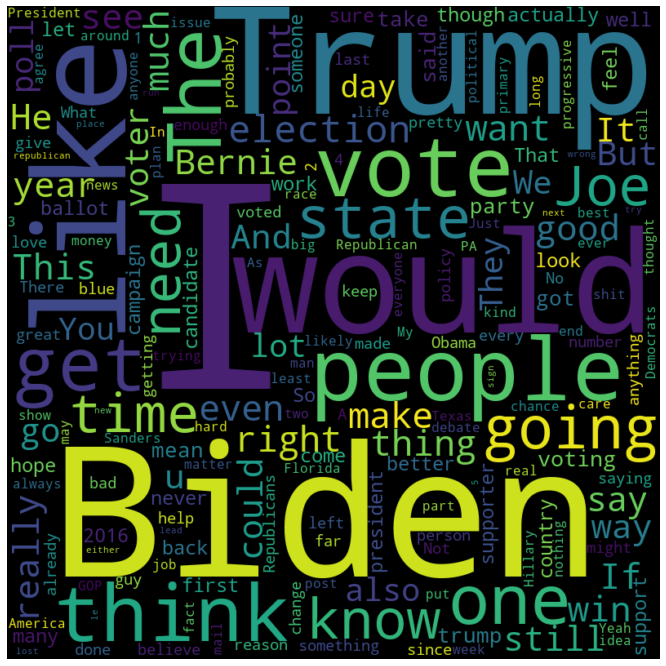

In [150]:
counter, word_freq = wordcloud(data)



In [151]:
def wordcloud_by_date(dataset, year=None, month=None, day=None):
    dataset_cp = dataset.copy()
    
    if year:
        dataset_cp = dataset_cp[dataset_cp['year'] == year]
    if month:
        dataset_cp = dataset_cp[dataset_cp['month'] == month]
    if day:
        dataset_cp = dataset_cp[dataset_cp['day'] == day]
    
    return wordcloud(dataset_cp)

  0%|          | 0/49957 [00:00<?, ?it/s]

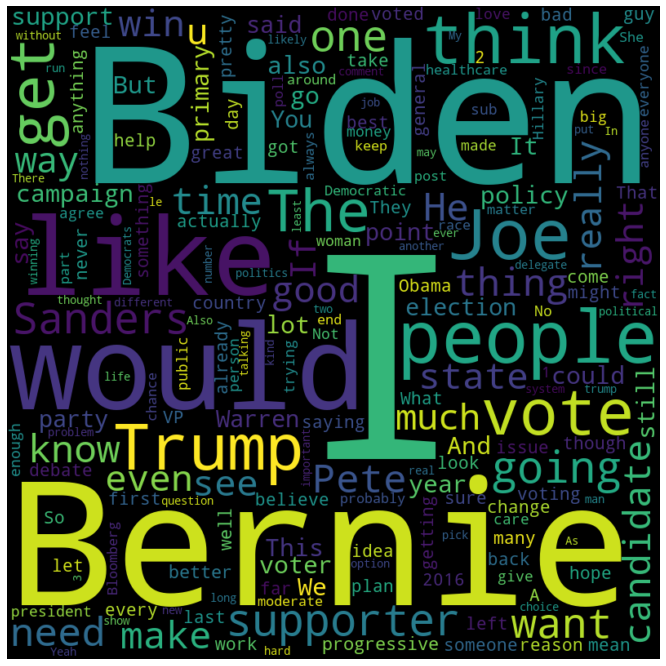

In [152]:
counter_march, word_freq_march = wordcloud_by_date(data, month=3)

Можно хорошо видеть как снижается количество обсуждений Берни Сандерса. Любопытно, что ничего связанного с ковидом в облаке нет! Но в целом, причиной увеличения числа постов скорее всего всё ещё является локдаун. 

  0%|          | 0/31220 [00:00<?, ?it/s]

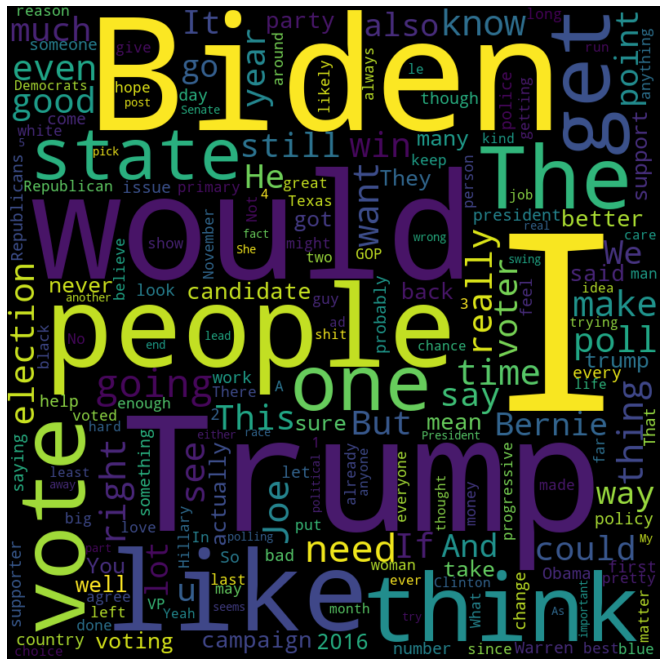

In [153]:
counter_june, word_freq_june = wordcloud_by_date(data, month=6)

  0%|          | 0/121206 [00:00<?, ?it/s]

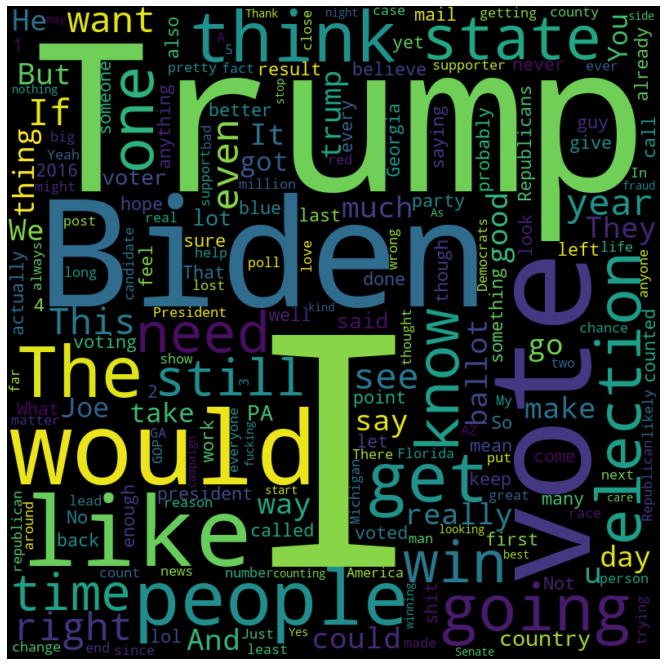

In [154]:
counter_november, word_freq_november = wordcloud_by_date(data, month=11)

  0%|          | 0/23361 [00:00<?, ?it/s]

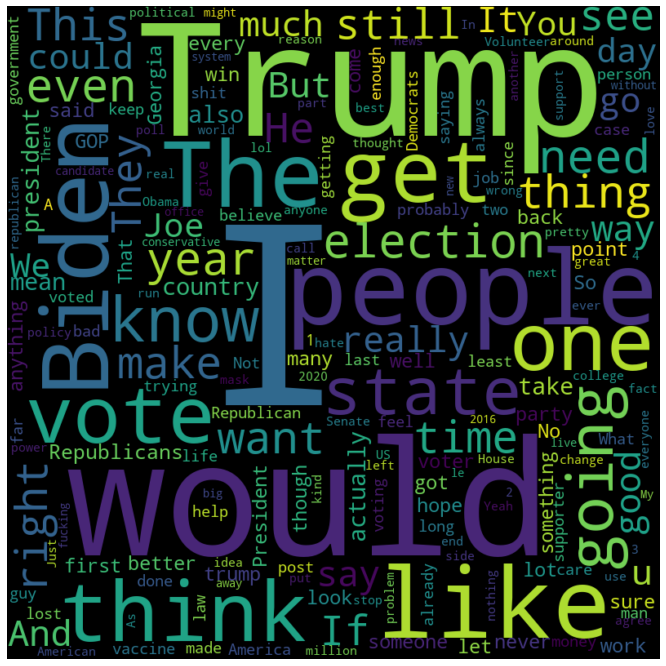

In [155]:
counter_december, word_freq_december = wordcloud_by_date(data, month=12)

  0%|          | 0/23545 [00:00<?, ?it/s]

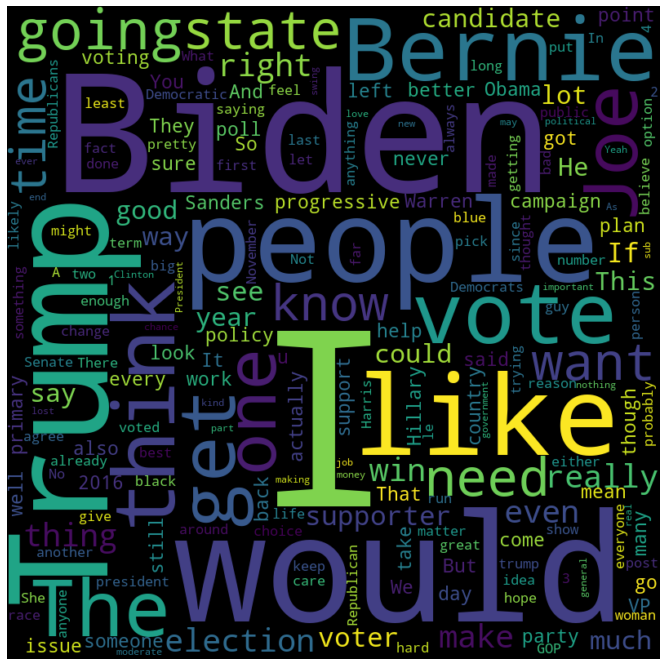

In [156]:
counter_april, word_freq_april = wordcloud_by_date(data, month=4)

  0%|          | 0/24442 [00:00<?, ?it/s]

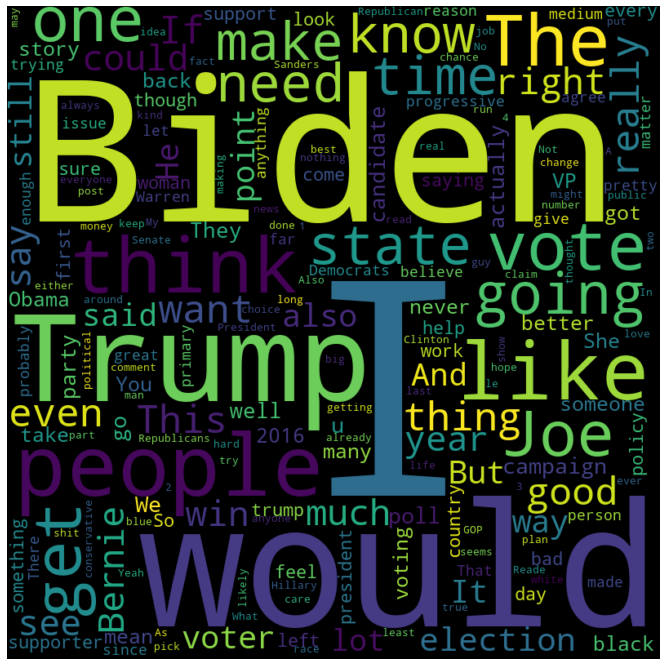

In [157]:
counter_may, word_freq_may = wordcloud_by_date(data, month=5)

  0%|          | 0/30461 [00:00<?, ?it/s]

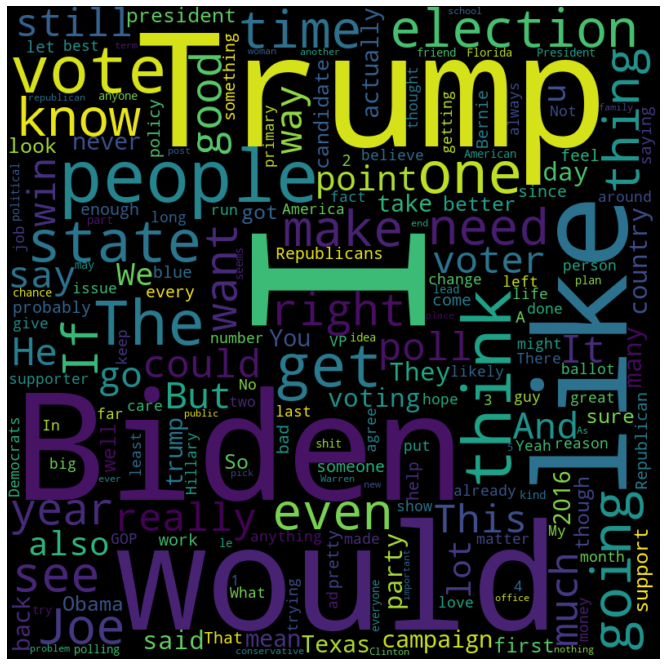

In [158]:
counter_july, word_freq_july = wordcloud_by_date(data, month=7)

  0%|          | 0/41014 [00:00<?, ?it/s]

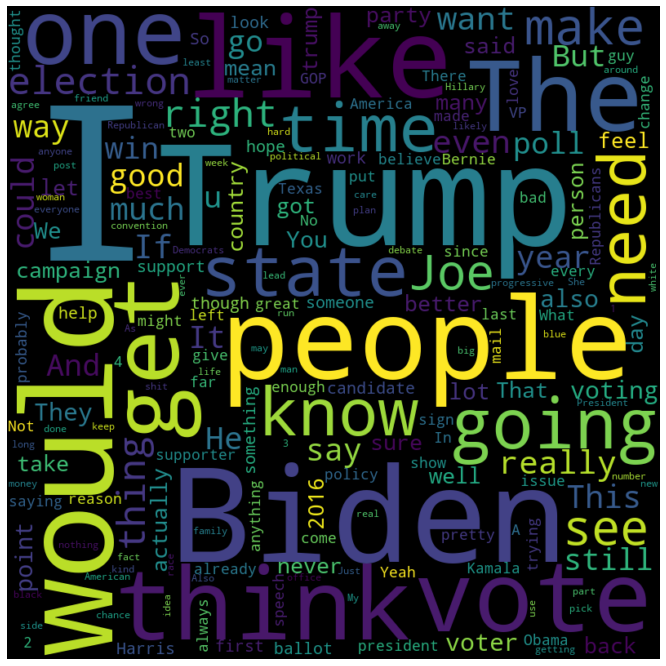

In [159]:
counter_august, word_freq_august = wordcloud_by_date(data, month=8)

  0%|          | 0/52231 [00:00<?, ?it/s]

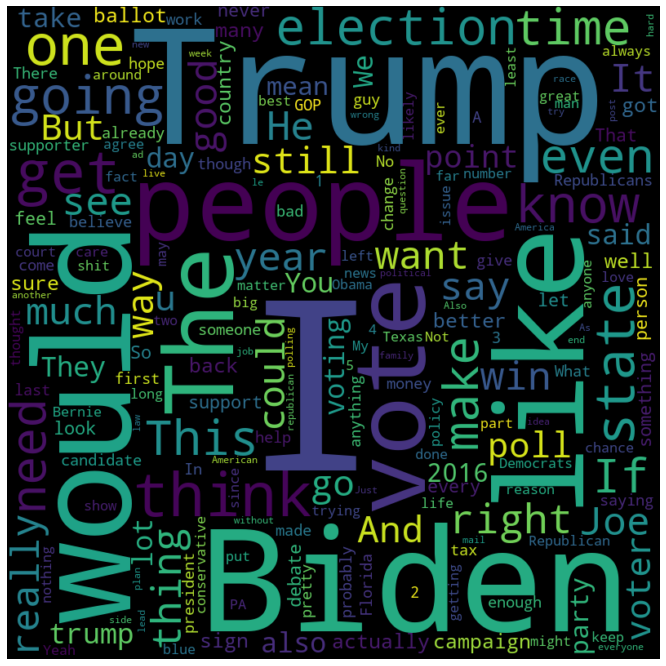

In [160]:
counter_september, word_freq_september = wordcloud_by_date(data, month=9)

  0%|          | 0/92640 [00:00<?, ?it/s]

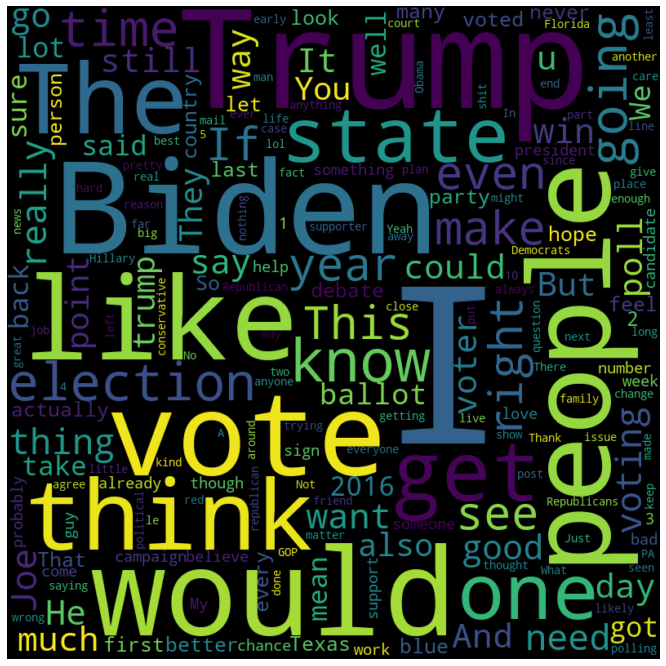

In [161]:
counter_october, word_freq_october = wordcloud_by_date(data, month=10)

  0%|          | 0/6006 [00:00<?, ?it/s]

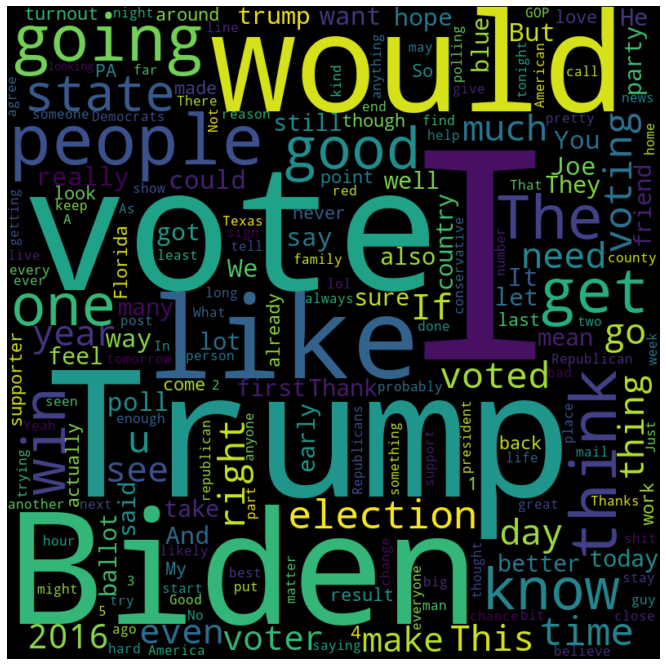

In [162]:
counter_preelection_day, word_freq_preelection_day = wordcloud_by_date(data, month=11, day = 3)

  0%|          | 0/31328 [00:00<?, ?it/s]

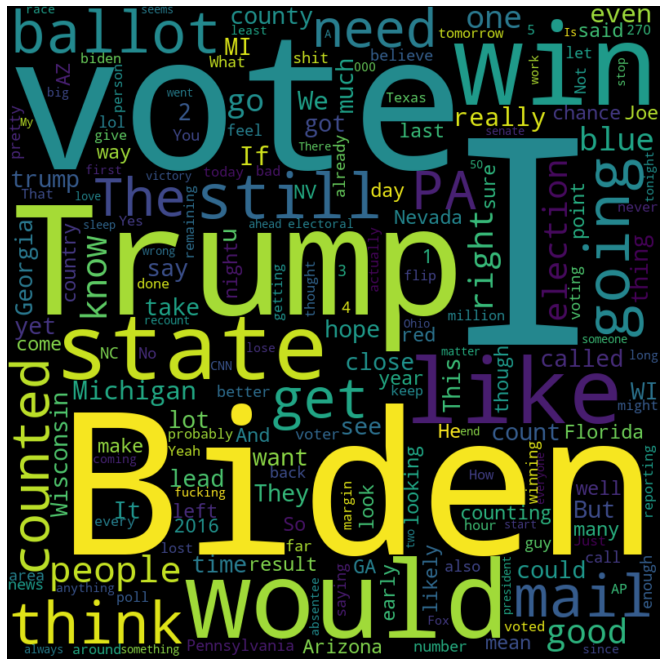

In [163]:
counter_election_day, word_freq_election_day = wordcloud_by_date(data, month=11, day = 4)

По мере приближения к выборам из повестки выпадают все фамилии кроме Байдена и Трампа (Обама, Клинтон, Сандерс) и т.д. Споры явно становятся горячее, больше агитации. Самые обсуждаемые штаты в целом - Техас и Флорида, мелькают больше всего. 

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


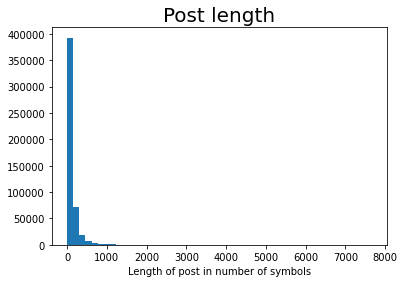

In [164]:
post_length = data['detokenized'].str.len()

plt.title('Post length', size = 20)
sns.distplot(post_length, kde = False,
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of post in number of symbols')
plt.show()

Распределение длины постов в символах. Есть единичные просто огромные посты. 

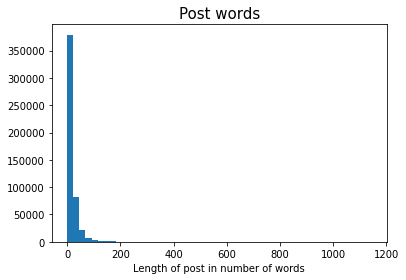

In [165]:
post_words = data['lemmatized'].map(lambda x: len(x))

plt.title('Post words', size = 15)
sns.distplot(post_words, kde = False,
             hist_kws = dict(alpha = 1))
plt.xlabel('Length of post in number of words')
plt.show()

/opt/conda/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/opt/conda/lib/python3.7/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


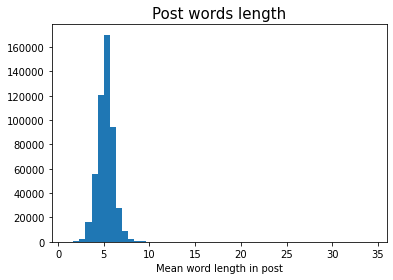

In [166]:
post_word_len = data['lemmatized'].apply(lambda x: [len(i) for i in x]).map(lambda x: np.mean(x))

plt.title('Post words length', size = 15, color = 'black')
sns.distplot(post_word_len, kde = False,  
             hist_kws = dict(alpha = 1))
plt.xlabel('Mean word length in post')
plt.show()

In [167]:

def top_20_words(data):
        words = data['lemmatized'].values.tolist()
        post_corpus = [word for i in words for word in i]

        post_counter = Counter(post_corpus)
        post_most = post_counter.most_common()

        stop = set(stopwords.words('english'))

        post_top_words, post_top_words_count = [], []
        for word, count in post_most[:20]:
            if word not in stop:
                post_top_words.append(word)
                post_top_words_count.append(count)
        plt.title('TOP-20 words', color = 'black', size = 15)
        sns.barplot(y = post_top_words[:20], x = post_top_words_count[:20], 
                    edgecolor = 'black', color = 'blue')
        plt.show()

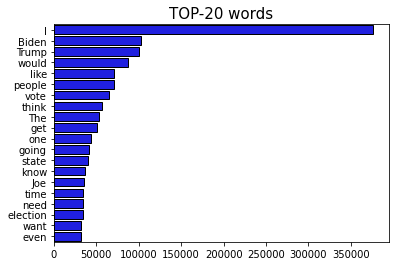

In [168]:
top_20_words(data)

In [169]:
def top20_words_by_date(dataset, year=None, month=None, day=None):
    dataset_cp = dataset.copy()
    
    if year:
        dataset_cp = dataset_cp[dataset_cp['year'] == year]
    if month:
        dataset_cp = dataset_cp[dataset_cp['month'] == month]
    if day:
        dataset_cp = dataset_cp[dataset_cp['day'] == day]
    
    return top_20_words(dataset_cp)

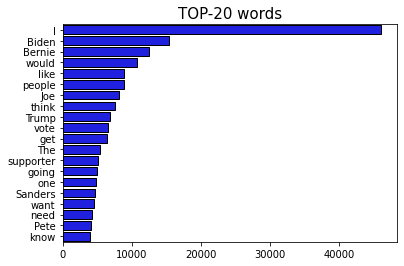

In [170]:
top20_words_by_date(data, month = 3)

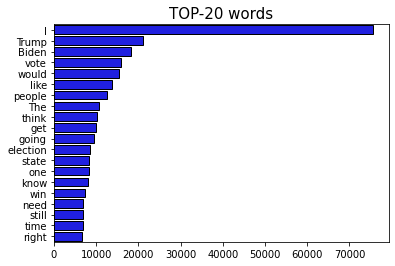

In [171]:
top20_words_by_date(data, month = 11)

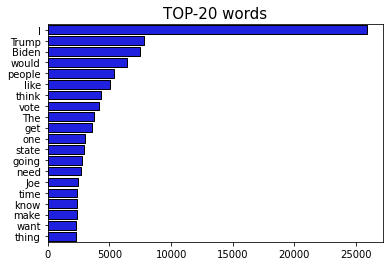

In [172]:
top20_words_by_date(data, month = 6)

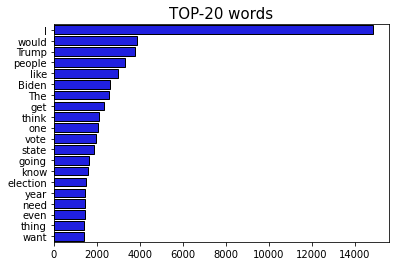

In [173]:
top20_words_by_date(data, month = 12)

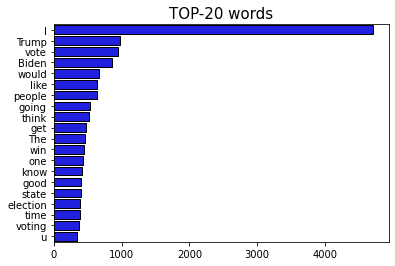

In [174]:
top20_words_by_date(data, month = 11, day = 3)

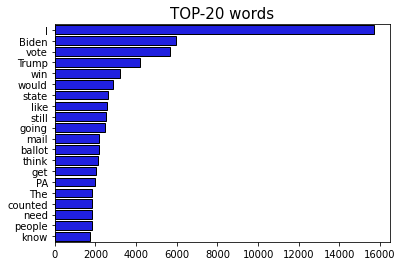

In [175]:
top20_words_by_date(data, month = 11, day = 4)

В целом, не очень репрезентативно. В день выборов по понятным причинам обсуждали голосование по почте. В остальном выделяется разве что наличие имени Сандерса в марте. Надо глянуть, что было с ним связано в марте. Посмотрим нграммы.

In [176]:
def get_top_ngram(corpus, n = 2):
    vec = CountVectorizer(stop_words = stop, ngram_range = (n, n)).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
    return words_freq

In [177]:
from sklearn.feature_extraction.text import CountVectorizer
top_bigrams = get_top_ngram(data['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))


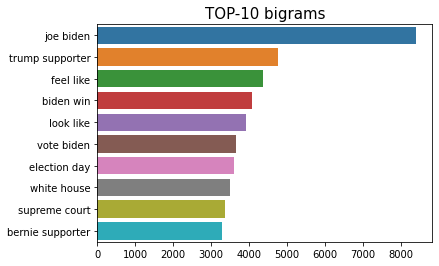

In [178]:
plt.title('TOP-10 bigrams', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

In [179]:
top_trigrams = get_top_ngram(data['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))

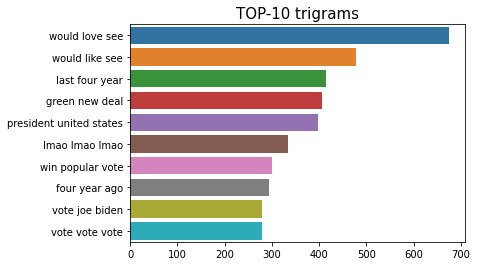

In [180]:
plt.title('TOP-10 trigrams', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

Судя по всему, много агитации, сокрушений о сроке трампа и призывов не совершать ошибку 2016го 

In [328]:
data_november = data[data['month'] == 11]
data_march = data[data['month'] == 3]
data_april = data[data['month'] == 4]
data_may = data[data['month'] == 5]
data_december = data[data['month'] == 12]
data_june = data[data['month'] == 6]

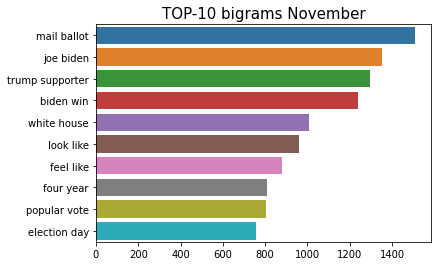

In [182]:
top_bigrams = get_top_ngram(data_november['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))
plt.title('TOP-10 bigrams November', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

Голосование по почте самая популярная тема ноября, это мы уже поняли и так. 

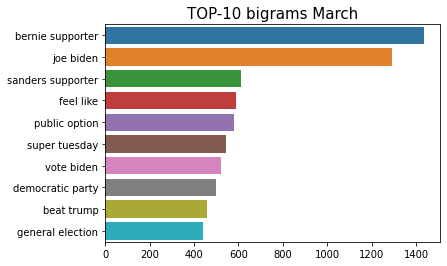

In [183]:
top_bigrams = get_top_ngram(data_march['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))
plt.title('TOP-10 bigrams March', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

Обсуждения Берни в Марте, снова. 

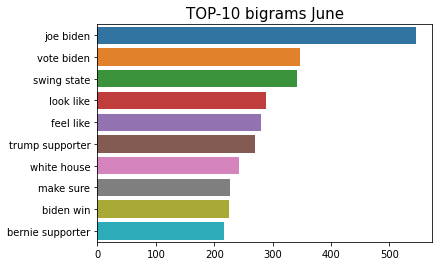

In [184]:
top_bigrams = get_top_ngram(data_june['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))
plt.title('TOP-10 bigrams June', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

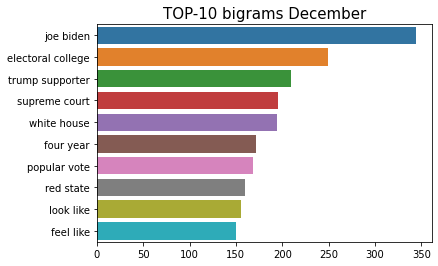

In [185]:
top_bigrams = get_top_ngram(data_december['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))
plt.title('TOP-10 bigrams December', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

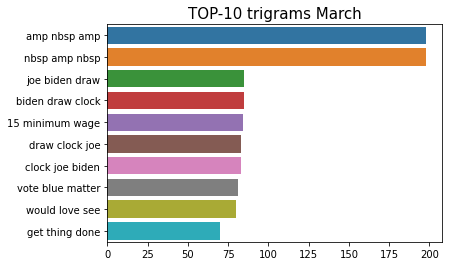

In [323]:
top_trigrams = get_top_ngram(data_march['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))
plt.title('TOP-10 trigrams March', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

In [187]:
data_march['detokenized'] = data_march['detokenized'].progress_apply(lambda x: x.lower())

  0%|          | 0/49957 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [188]:
meme_posts = [x for x in data_march['detokenized'] if 'clock' in x and 'biden' in x]

In [189]:
len(meme_posts)

5

In [190]:
meme_posts

['i sure looked mcconnell position joe vote prior 2008 would probably line pretty well here i already done half work biden readily available quick snapshot joe biden accomplishment throughout career 1975 voted desegregation said want child grow racial jungle 1976 2019 supported hyde amendment prevents federal funding used abortion except case danger woman rape incest 1981 voted end federal funding abortion case rape incest 1981 voted favor amendment would overturn roe v wade 1982 voted favor amendment would overturn roe v wade again 1983 introduced comprehensive forfeiture act increased use civil asset forfeiture law enforcement 1986 voted favor bill allowing sale firearm us postal service reduce ability federal inspector scrutinize sale firearm gun show later back tracked 1999 in defense call vote cast opposition stricter gun control law 1986 introduced first climate change bill senate i give one 1986 co wrote anti drug abuse act increased average prison time crack cocaine user epidem

О, период распространения мема "может ли Джо Байден нарисовать часы". Однако видим, что на самом деле тут имеет место попытка обмана, видим, что в топ триграм в этом месяце мем выбрался благодаря одному (!) спамерскому посту. 

In [239]:
data_march['bernie_posts'] = data_march['detokenized'].str.contains('bernie')
data_march['sanders_posts'] = data_march['detokenized'].str.contains('sanders')

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [313]:
data_bernie = data_march[(data_march['bernie_posts'] == True) | (data_march['sanders_posts'] == True)]

In [308]:
data_bernie['Length'] = data_bernie['tokenized'].progress_apply(lambda x: len(x))
data_bernie = data_bernie[data_bernie['Length'] < 512]

#data_bernie = data_bernie.filter(['author', 'body', 'detokenized'])

  0%|          | 0/11661 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [314]:
data_bernie = data_bernie.filter(['author', 'body', 'detokenized'])

In [315]:
data_bernie

author                                               body  \
9450            NYforTrump  Congrats / on the big win! This might be a big...   
9453               Atlas26  This is singlehandedly one of the most batshit...   
9454             etherspin  MSNBC says Joe is already 9 points ahead of Pe...   
9455      ButterCupHeartXO  Was it the bots and russians going to the poll...   
9461      politicalthrow99  We did it, we bashed him, Joe Biden's the one!...   
...                    ...                                                ...   
59304    josephthemediocre  Look I voted for Bernie. But the way the democ...   
59307  Left_Sustainability  The toxicity regarding Reade today on Twitter ...   
59313     TheAmazingThanos  Sorry, I was sarcastically making fun of Sande...   
59337           notasoiboy  This is 2020 Sanders vrs Trump. Sanders had cl...   
59364            KYWildMan  Stop. Making. Wisconsin. Red. But. Not. Arizon...   

                                             detokenized  
9450   congrats big win this might big turning point ...  
9453   this singlehandedly one batshit insane bernie ...  
9454   msnbc say joe already 9 point ahead pete deleg...  
9455     was bot russian going poll given bernie victory  
9461   we bashed joe biden one and bernie gone dirty ...  
...                                                  ...  
59304  look i voted bernie but way democratic primary...  
59307  the toxicity regarding reade today twitter bub...  
59313  sorry i sarcastically making fun sanders suppo...  
59337  this 2020 sanders vrs trump sanders close race...  
59364  stop making wisconsin red but not arizona or n...  

[11661 rows x 3 columns]

In [316]:
from transformers import pipeline
classifier = pipeline('sentiment-analysis')

In [317]:
batch_size = 1
sequences = data_bernie['detokenized'].to_list()
results = []
for i in range(0, len(sequences), batch_size):
    results += classifier(sequences[i:i+batch_size], truncation = True)

In [321]:
results_positive = [d['label'] for d in results if d['label'] == 'POSITIVE']
len(results_positive)

2476

In [322]:
results_negative = [d['label'] for d in results if d['label'] == 'NEGATIVE']
len(results_negative)

9185

В марте постов про Берни относительно много, но среди них больше негативно окрашенных. Посмотрим, как меняется отношение к нему. 

In [324]:
data_june['detokenized'] = data_june['detokenized'].progress_apply(lambda x: x.lower())
data_june['bernie_posts'] = data_june['detokenized'].str.contains('bernie')
data_june['sanders_posts'] = data_june['detokenized'].str.contains('sanders')
data_bernie_june = data_june[(data_june['bernie_posts'] == True) | (data_june['sanders_posts'] == True)]
data_bernie_june['Length'] = data_bernie_june['tokenized'].progress_apply(lambda x: len(x))
data_bernie_june = data_bernie_june[data_bernie_june['Length'] < 512]
batch_size = 1
sequences = data_bernie_june['detokenized'].to_list()
results = []
for i in range(0, len(sequences), batch_size):
    results += classifier(sequences[i:i+batch_size], truncation = True)

  0%|          | 0/31220 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

  0%|          | 0/1368 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [325]:
results_positive = [d['label'] for d in results if d['label'] == 'POSITIVE']
len(results_positive)

338

In [327]:
results_negative = [d['label'] for d in results if d['label'] == 'NEGATIVE']
len(results_negative)

1029

In [330]:
data_april['detokenized'] = data_april['detokenized'].progress_apply(lambda x: x.lower())
data_april['bernie_posts'] = data_april['detokenized'].str.contains('bernie')
data_april['sanders_posts'] = data_april['detokenized'].str.contains('sanders')
data_bernie_april = data_april[(data_april['bernie_posts'] == True) | (data_april['sanders_posts'] == True)]
data_bernie_april['Length'] = data_bernie_april['tokenized'].progress_apply(lambda x: len(x))
data_bernie_april = data_bernie_april[data_bernie_april['Length'] < 512]
batch_size = 1
sequences = data_bernie_april['detokenized'].to_list()
results = []
for i in range(0, len(sequences), batch_size):
    results += classifier(sequences[i:i+batch_size], truncation = True)

  0%|          | 0/23545 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

  0%|          | 0/3345 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [331]:
results_positive = [d['label'] for d in results if d['label'] == 'POSITIVE']
len(results_positive)

787

In [332]:
results_negative = [d['label'] for d in results if d['label'] == 'NEGATIVE']
len(results_negative)

2556

In [333]:
data_may['detokenized'] = data_may['detokenized'].progress_apply(lambda x: x.lower())
data_may['bernie_posts'] = data_may['detokenized'].str.contains('bernie')
data_may['sanders_posts'] = data_may['detokenized'].str.contains('sanders')
data_bernie_may = data_may[(data_may['bernie_posts'] == True) | (data_may['sanders_posts'] == True)]
data_bernie_may['Length'] = data_bernie_may['tokenized'].progress_apply(lambda x: len(x))
data_bernie_may = data_bernie_may[data_bernie_may['Length'] < 512]
batch_size = 1
sequences = data_bernie_may['detokenized'].to_list()
results = []
for i in range(0, len(sequences), batch_size):
    results += classifier(sequences[i:i+batch_size], truncation = True)

  0%|          | 0/24442 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

  0%|          | 0/1373 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [334]:
results_positive = [d['label'] for d in results if d['label'] == 'POSITIVE']
len(results_positive)

296

In [335]:
results_negative = [d['label'] for d in results if d['label'] == 'NEGATIVE']
len(results_negative)

1076

В целом больше всего негативных отзывов и это не меняется, просто спадает интерес к Берни. В Марте все еще пик интереса к нему. 

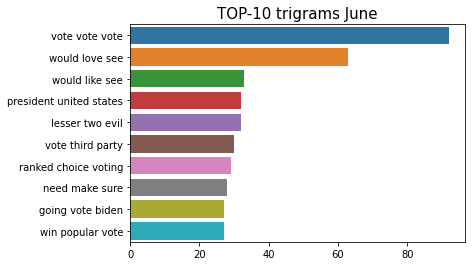

In [194]:
top_trigrams = get_top_ngram(data_june['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))
plt.title('TOP-10 trigrams June', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

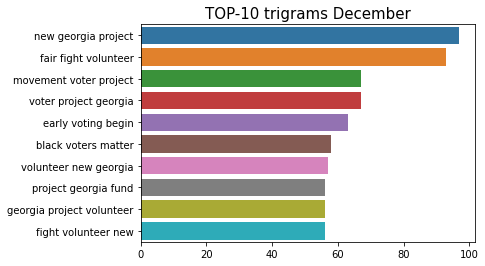

In [195]:
top_trigrams = get_top_ngram(data_december['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))
plt.title('TOP-10 trigrams December', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

Еще одна локальная тема, проект Нью Джорджия. 

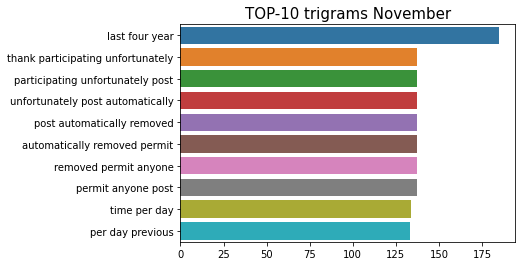

In [196]:
top_trigrams = get_top_ngram(data_november['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))
plt.title('TOP-10 trigrams November', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

О, интересно. Судя по всему в Ноябре реддит автоматически удалял много постов!

In [197]:
data_october = data[data['month'] == 10]

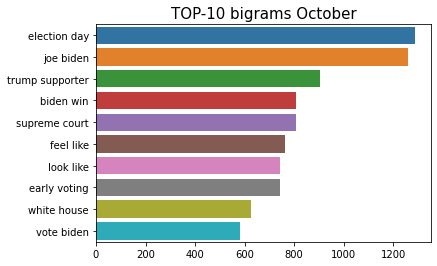

In [198]:
top_bigrams = get_top_ngram(data_october['detokenized'], 2)[:10]
title_x, title_y = map(list, zip(*top_bigrams))
plt.title('TOP-10 bigrams October', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()

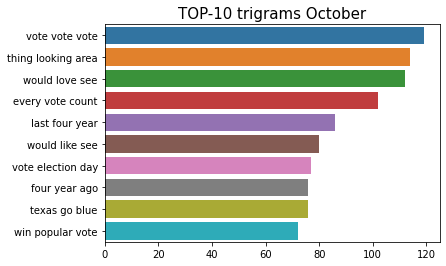

In [199]:
top_trigrams = get_top_ngram(data_october['detokenized'], 3)[:10]
title_x, title_y = map(list, zip(*top_trigrams))
plt.title('TOP-10 trigrams October', color = 'black', size = 15)
sns.barplot(x = title_y, y = title_x)
plt.show()